In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils
from sbi import analysis
from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
import numpy as np

# set seed for numpy and torch
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
meta_dict={
        'n_dense_s1': 2,
        'n_dense_s2': 2,
        'n_dense_s3': 2,
        'n_equiv':    2,
        'dense_s1_args': {'in_features':1024, 'out_features': 32},
        'dense_s2_args': {'in_features':1024,  'out_features': 64},
        'dense_s3_args': {'in_features':1024, 'out_features': 32}
    }

Invariant Module


In [30]:
class InvariantModule(nn.Module):
    """Implements an invariant module with keras."""
    
    def __init__(self, meta=meta_dict, input_dim = 1024):
        super(InvariantModule, self).__init__()
        
        #self.s1 = Sequential([Dense(**meta['dense_s1_args']) for _ in range(meta['n_dense_s1'])])
        #self.s2 = Sequential([Dense(**meta['dense_s2_args']) for _ in range(meta['n_dense_s2'])])
        self.input_dim = input_dim
        self.s1 = nn.Sequential(nn.Linear(in_features = self.input_dim, out_features=32), nn.ReLU(), nn.Linear(in_features= 32, out_features=32), nn.ReLU())
        self.s2 = nn.Sequential(nn.Linear(in_features=32, out_features=64), nn.ReLU(), nn.Linear(in_features=64, out_features=64), nn.ReLU())
    def call(self, x):
        """Performs the forward pass of a learnable invariant transform.
        
        Parameters
        ----------
        x : tf.Tensor
            Input of shape (batch_size, N, x_dim)
        
        Returns
        -------
        out : tf.Tensor
            Output of shape (batch_size, out_dim)
        """
        x_reduced = torch.mean(self.s1(x), axis=1)
        out = self.s2(x_reduced)
        return out

class EquivariantModule(nn.Module):
    """Implements an equivariant module with keras."""
    
    def __init__(self, meta=meta_dict, input_dim=1024):
        super(EquivariantModule, self).__init__()
        self.input_dim=input_dim
        self.invariant_module = InvariantModule(meta, input_dim = self.input_dim)
        print('Finished creating Invariant Module')
        self.s3 = nn.Sequential(nn.Linear(in_features = self.input_dim + 64, out_features=32), nn.ReLU(), nn.Linear(in_features= 32, out_features=32), nn.ReLU())
                    
    def call(self, x):
        """Performs the forward pass of a learnable equivariant transform.
        
        Parameters
        ----------
        x : tf.Tensor
            Input of shape (batch_size, N, x_dim)
        
        Returns
        -------
        out : tf.Tensor
            Output of shape (batch_size, N, equiv_dim)
        """
        
        # Store N
        N = int(x.shape[1])
        
        # Output dim is (batch_size, inv_dim) - > (batch_size, N, inv_dim)
        out_inv = self.invariant_module.call(x)
        out_inv_rep = torch.stack([out_inv] * N, axis=1)
        
        # Concatenate each x with the repeated invariant embedding
        out_c = torch.cat([x, out_inv_rep], axis=-1)
        
        # Pass through equivariant func
        out = self.s3(out_c)
        return out

class InvariantNetwork(nn.Module):
    """Implements an invariant network with keras.
    """

    def __init__(self, meta={}, input_dim=1024):
        super(InvariantNetwork, self).__init__()

        #meta = build_meta_dict(user_dict=meta,
                               #default_setting=default_settings.DEFAULT_SETTING_INVARIANT_NET)
        self.input_dim = input_dim
        self.equiv_seq1 = EquivariantModule()
        self.equiv_seq2 = EquivariantModule(input_dim=32)
        self.inv = InvariantModule(input_dim=32)
    
    def __call__(self, x):
        """ Performs the forward pass of a learnable deep invariant transformation consisting of
        a sequence of equivariant transforms followed by an invariant transform.
        
        Parameters
        ----------
        x : tf.Tensor
            Input of shape (batch_size, n_obs, data_dim)
        
        Returns
        -------
        out : tf.Tensor
            Output of shape (batch_size, out_dim + 1)
        """
        
        # Extract n_obs and create sqrt(N) vector
        N = int(x.shape[1])
        N_rep = torch.sqrt(N * torch.ones((x.shape[0], 1)))
        print(x.shape[0])
        print(N_rep.shape)
        # Pass through series of augmented equivariant transforms
        out_equiv = self.equiv_seq2.call(self.equiv_seq1.call(x))

        # Pass through final invariant layer and concatenate with N_rep
        out_inv = self.inv.call(out_equiv)
        #out = torch.cat((out_inv, N_rep), axis=-1)
        
        return out_inv

In [86]:
 def simulator_model(parameter, return_points=False):
    """ Simulator model with two-dimensional input parameter and 1024-dimensional output

    This simulator serves as a basic example for using a neural net for learning summary features. 
    It has only two input parameters but generates high-dimensional output vectors.
    The data is generated as follows:
        (-) Input:  parameter = [r, theta]
        (1) Generate 100 two-dimensional points centered around (r cos(theta),r sin(theta))  
            and perturbed by a Gaussian noise with variance 0.01
        (2) Create a grayscale image I of the scattered points with dimensions 32 by 32
        (3) Perturb I with an uniform noise with values betweeen 0 and 0.2
        (-) Output: I 

    Parameters
    ----------
    parameter : array-like, shape (2)
        The two input parameters of the model, ordered as [r, theta]
    return_points : bool (default: False)
        Whether the simulator should return the coordinates of the simulated data points as well

    Returns
    -------
    I: torch tensor, shape (1, 1024)    
        Output flattened image
    (optional) points: array-like, shape (100, 2)
        Coordinates of the 2D simulated data points 

    """
    r = parameter[0]
    theta = parameter[1]

    sigma_points = 0.10
    npoints = 100
    points = []
    for _ in range(npoints):
        x = r * np.cos(theta) + sigma_points * np.random.randn()
        y = r * np.sin(theta) + sigma_points * np.random.randn()
        points.append([x, y])
    points = np.array(points)

    nx = 32
    ny = 32
    sigma_image = 0.20
    I = np.zeros((nx, ny))
    for point in points:
        pi = int((point[0] - (-1)) / ((+1) - (-1)) * nx)
        pj = int((point[1] - (-1)) / ((+1) - (-1)) * ny) 
        if (pi < nx) and (pj < ny):   
            I[pi, pj] = 1
    I = I + sigma_image * np.random.rand(nx, ny)    
    I = I.T
    I = I.reshape(1,-1)
    I = torch.tensor(I, dtype=torch.get_default_dtype())

    if return_points:
        return I, points
    else:
        return I


In [31]:
network = InvariantNetwork()

Finished creating Invariant Module
Finished creating Invariant Module


In [32]:
data = np.random.normal(size = (64, 100, 1024)).astype(np.float32)

In [33]:
network(torch.tensor(data)).shape

64
torch.Size([64, 1])


torch.Size([64, 64])

Text(0.5, 1.0, 'noisy observed data (gray image with 32 x 32 pixels)')

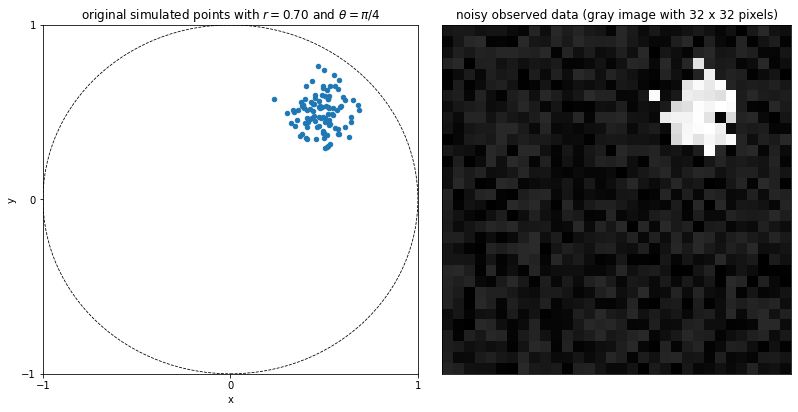

In [87]:
# simulate samples
true_parameter = torch.tensor([0.70, np.pi/4])
x_observed, x_points = simulator_model(true_parameter, return_points=True)

# plot the observation
fig, ax = plt.subplots(facecolor='white', figsize=(11.15, 5.61), ncols=2, constrained_layout=True)
circle = plt.Circle((0, 0), 1.0, color='k', ls='--', lw=0.8, fill=False)
ax[0].add_artist(circle)
ax[0].scatter(x_points[:,0], x_points[:,1], s=20)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_xlim(-1, +1)
ax[0].set_xticks([-1, 0.0, +1.0])
ax[0].set_ylim(-1, +1)
ax[0].set_yticks([-1, 0.0, +1.0])
ax[0].set_title(r'original simulated points with $r = 0.70$ and $\theta = \pi/4$')
ax[1].imshow(x_observed.view(32, 32), origin='lower', cmap='gray')
ax[1].set_xticks([]); ax[1].set_yticks([])
ax[1].set_title('noisy observed data (gray image with 32 x 32 pixels)')


In [72]:
x_points.shape

(100, 2)

In [88]:
class SummaryNet(nn.Module): 

    def __init__(self): 
        super().__init__()
        # 2D convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        # Maxpool layer that reduces 32x32 image to 4x4
        self.pool = nn.MaxPool2d(kernel_size=8, stride=8)
        # Fully connected layer taking as input the 6 flattened output arrays from the maxpooling layer
        self.fc = nn.Linear(in_features=6*4*4, out_features=8) 

    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 6*4*4)
        x = F.relu(self.fc(x))
        return x

embedding_net = InvariantNetwork()


Finished creating Invariant Module
Finished creating Invariant Module


In [89]:
# set prior distribution for the parameters 
prior = utils.BoxUniform(low=torch.tensor([0.0, 0.0]), 
                             high=torch.tensor([1.0, 2*np.pi]))                           

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator_model, prior)

# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(model='maf', 
                                      embedding_net=embedding_net,
                                      hidden_features=10,
                                      num_transforms=2)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

# run the inference procedure on one round and 10000 simulated data points
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10000)
x = torch.reshape(x, [10000,1, 1024])
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)


/users/avo2/miniconda3/envs/sbitest/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/users/avo2/miniconda3/envs/sbitest/lib/python3.7/site-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

I am appending simulations!!!!!
 Neural network successfully converged after 27 epochs.

In [97]:
prior.sample()

tensor([0.7129, 3.7591])

In [6]:
# generate posterior samples
true_parameter = torch.tensor([0.70, np.pi/4])
x_observed = simulator_model(true_parameter)
x_observed = x_observed.reshape([1,1,1024])
samples = posterior.set_default_x(x_observed).sample((50000,))

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

In [90]:
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=1)


In [93]:
theta[0]

tensor([0.4340, 0.7605])

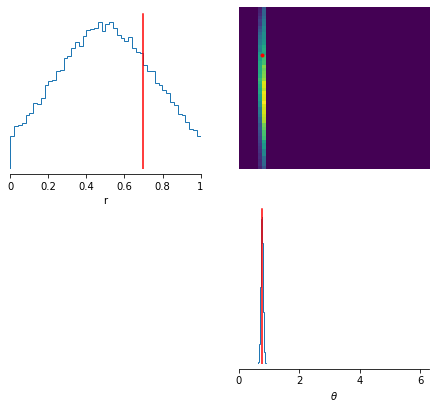

In [8]:
# create the figure
fig, ax = analysis.pairplot(samples, 
                             points=true_parameter,
                             labels=['r', r'$\theta$'], 
                             limits=[[0, 1], [0, 2*np.pi]],
                             points_colors='r',
                             points_offdiag={'markersize': 6},
                             figsize=[7.5, 6.4])

In [5]:
meta_dict={
        'n_dense_s1': 2,
        'n_dense_s2': 2,
        'n_dense_s3': 2,
        'n_equiv':    2,
        'dense_s1_args': {'in_features':1024, 'out_features': 32},
        'dense_s2_args': {'in_features':1024,  'out_features': 64},
        'dense_s3_args': {'in_features':1024, 'out_features': 32}
    }
equiv = InvariantNetwork(meta = meta_dict)

NameError: name 'InvariantNetwork' is not defined

In [18]:
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=1)

In [19]:
theta

tensor([[0.4362, 3.2266]])

In [58]:
equiv.call(reshaped_x)

torch.Size([10, 1000, 1024])
torch.Size([10, 32])
torch.Size([10, 64])
torch.Size([10, 1000, 32])
torch.Size([10, 32])
torch.Size([10, 64])
torch.Size([10, 1000, 32])
torch.Size([10, 32])
torch.Size([10, 64])


tensor([[7.7750e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.7544e-02, 2.2613e-02, 7.1941e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 4.5789e-02, 0.0000e+00, 7.4544e-03, 4.1590e-03,
         1.7318e-01, 0.0000e+00, 0.0000e+00, 2.4878e-02, 1.8642e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 6.8303e-06, 0.0000e+00, 9.0965e-02,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 4.1436e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0893e-01, 2.6902e-02, 0.0000e+00,
         8.7160e-02, 0.0000e+00, 6.2636e-02, 0.0000e+00, 0.0000e+00, 5.9866e-02,
         0.0000e+00, 4.7270e-02, 2.2553e-02, 0.0000e+00, 1.5931e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2239e-02, 9.3232e-02, 0.0000e+00,
         7.9786e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.1623e+01],
        [7.7746e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.7539e-02, 2.2617e-02, 7.1944

In [80]:
storeArray = torch.zeros(1000)
L = 100
for i in range(len(storeArray)):
    theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=1)
    x = x.reshape([1,1,1024])
    samples = posterior.set_default_x(x).sample((L,))
    rankR = torch.sum(torch.less(samples[:,0], theta[0][0]))
    storeArray[i] = rankR
    
    
    
    

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [110]:
storeArray = torch.zeros(2000)
L = 500
for i in range(len(storeArray)):
    theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=1)
    x = x.reshape([1,1,1024])
    #theta2, x2 = simulate_for_sbi(simulator_wrapper, prior, num_simulations=L)
    theta2 = prior.sample((L,))
    rankR = torch.sum(torch.less(theta2[:,1], theta[0][1]))
    storeArray[i] = rankR
    
    
    
    

In [81]:
prior = utils.BoxUniform(low=torch.tensor([0.0, 0.0]), 
                             high=torch.tensor([1.0, 2*np.pi]))   

(array([57., 69., 72., 72., 84., 65., 58., 65., 59., 69., 73., 55., 60.,
        68., 64., 78., 54., 52., 66., 56., 64., 65., 73., 72., 66., 75.,
        58., 67., 78., 86.]),
 array([  0.      ,  16.666666,  33.333332,  50.      ,  66.666664,
         83.333336, 100.      , 116.666664, 133.33333 , 150.      ,
        166.66667 , 183.33333 , 200.      , 216.66667 , 233.33333 ,
        250.      , 266.66666 , 283.33334 , 300.      , 316.66666 ,
        333.33334 , 350.      , 366.66666 , 383.33334 , 400.      ,
        416.66666 , 433.33334 , 450.      , 466.66666 , 483.33334 ,
        500.      ], dtype=float32),
 <BarContainer object of 30 artists>)

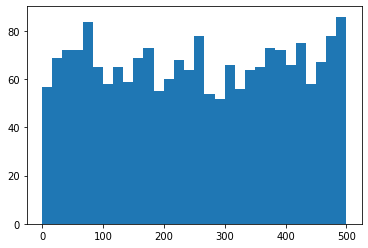

In [111]:
plt.hist(storeArray.numpy(), bins = 30)

<BarContainer object of 20 artists>

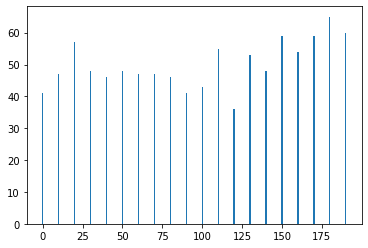

In [100]:
cnt, bins = np.histogram(storeArray, 20)
plt.bar(bins[:-1], cnt)

In [65]:
bins

tensor([  0.0000,   0.9901,   1.9802,   2.9703,   3.9604,   4.9505,   5.9406,
          6.9307,   7.9208,   8.9109,   9.9010,  10.8911,  11.8812,  12.8713,
         13.8614,  14.8515,  15.8416,  16.8317,  17.8218,  18.8119,  19.8020,
         20.7921,  21.7822,  22.7723,  23.7624,  24.7525,  25.7426,  26.7327,
         27.7228,  28.7129,  29.7030,  30.6931,  31.6832,  32.6733,  33.6634,
         34.6535,  35.6436,  36.6337,  37.6238,  38.6139,  39.6040,  40.5941,
         41.5842,  42.5743,  43.5644,  44.5545,  45.5446,  46.5347,  47.5248,
         48.5149,  49.5050,  50.4951,  51.4851,  52.4753,  53.4653,  54.4554,
         55.4455,  56.4356,  57.4257,  58.4158,  59.4059,  60.3960,  61.3861,
         62.3762,  63.3663,  64.3564,  65.3465,  66.3366,  67.3267,  68.3168,
         69.3069,  70.2970,  71.2871,  72.2772,  73.2673,  74.2574,  75.2475,
         76.2376,  77.2277,  78.2178,  79.2079,  80.1980,  81.1881,  82.1782,
         83.1683,  84.1584,  85.1485,  86.1386,  87.1287,  88.11

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([  0.       ,   0.990099 ,   1.980198 ,   2.970297 ,   3.960396 ,
          4.9504952,   5.940594 ,   6.930693 ,   7.920792 ,   8.910892 ,
          9.9009905,  10.891089 ,  11.881188 ,  12.871287 ,  13.861386 ,
         14.851485 ,  15.841584 ,  16.831684 ,  17.821783 ,  18.811882 ,
         19.801981 ,  20.79208  ,  21.782179 ,  22.772278 ,  23.762377 ,
         24.752476 ,  25.742575 ,  26.732674 ,  27.722773 ,  28.712872 ,
         29.70297  ,  30.69307  ,  31.683168 ,  32.673267 ,  33.66337  ,
         34.653465 ,  35.643566 ,  36.633663 ,  37.623764 ,  38.61386  ,
         39.603962 ,  40.59406  ,  41.58416  ,  42.574257 ,  43.564358 ,
         44.554455 ,  45.544556 ,  46.534653 ,  47.524754 ,  48.51485  ,
         49.50495  , 

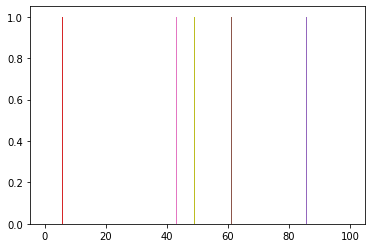

In [56]:
plt.hist(storeArray,density = False, bins = 101)
